In [68]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna

import pipeline as pipeline

import warnings
warnings.filterwarnings('ignore') # warnings are for the weak

sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files

plt.rcParams.update({'font.size' : 14})

In [38]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [39]:
def meanFiringRates(p):
    print("Mean Firing Rates")
    for pop in ["MGN", "TRN", "eA1", "iA1"]:
        print(pop, " : ", p.spikeobj[pop].mean_rate())
    
    print("Standard Deviation")
    for pop in ["MGN", "TRN", "eA1", "iA1"]:
        print(pop, " : ", p.spikeobj[pop].mean_rate_std())

In [40]:
! ls ../../demyelination/data/eaone-noise-demy-reload-end/activity/ -lt

total 1992
-rw-rw-r-- 1 pbr-student pbr-student 2037682 Mar 27 09:24 'spk_eaone-noise-demy-reload-end_T=0'


## End

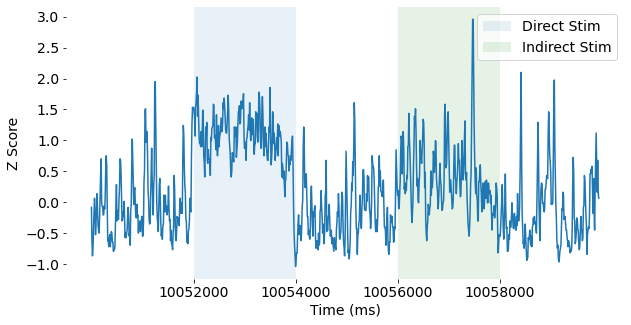

In [139]:
pth = "../../demyelination/data/eaone-noise-demy-reload-end/activity/"
f = ['spk_eaone-noise-demy-reload-end_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

ax.set_frame_on(False)
reload_time = 10050000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);

ax.legend()

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

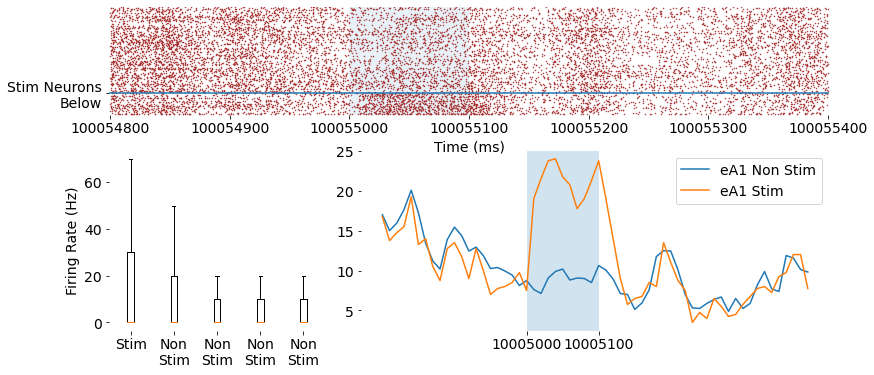

In [101]:
pth = "../../demyelination/data/eaone-noise-demy-reload-singlestim-end/activity/"
f = ['spk_eaone-noise-demy-reload-singlestim-end_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.axvspan(20, 30, alpha=.2)
ax.set_xticks([20, 30], [10005000, 10005100])

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+100050000)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 40000ms to 40100ms", fontsize=15);


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/tonostim-comparison-eaone.jpg")

## Halfway

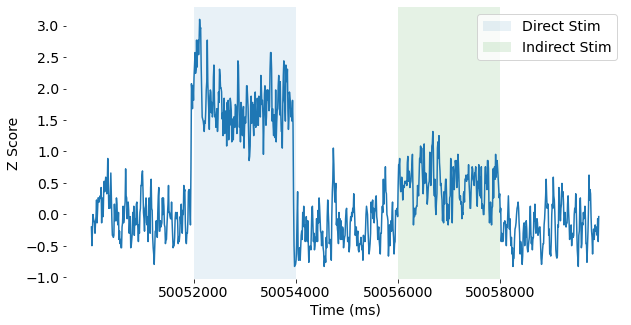

In [120]:
pth = "../../demyelination/data/eaone-noise-demy-reload-halfway/activity/"
f = ['spk_eaone-noise-demy-reload-halfway_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

ax.set_frame_on(False)
reload_time = 50050000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);

ax.legend()

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

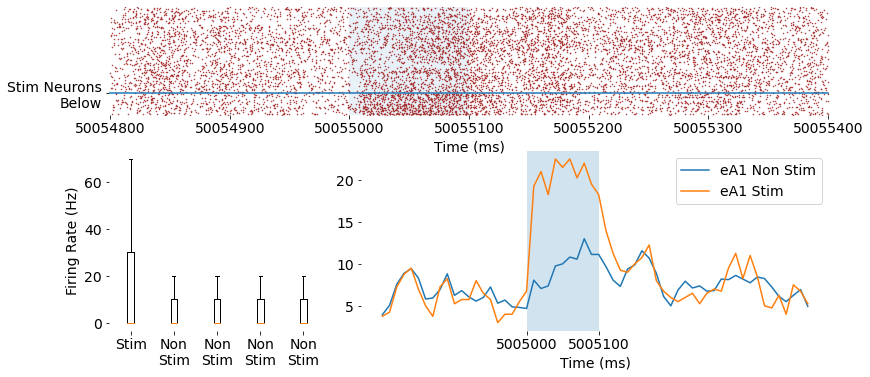

In [89]:
pth = "../../demyelination/data/eaone-noise-demy-reload-singlestim-halfway/activity/"
f = ['spk_eaone-noise-demy-reload-singlestim-halfway_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [5005000, 5005100])
ax.axvspan(20, 30, alpha=.2)
ax.set_xlabel("Time (ms)")

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+50050000)

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 5000ms to 5100ms", fontsize=15);


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/tonostim-comparison-eaone.jpg")

## Start

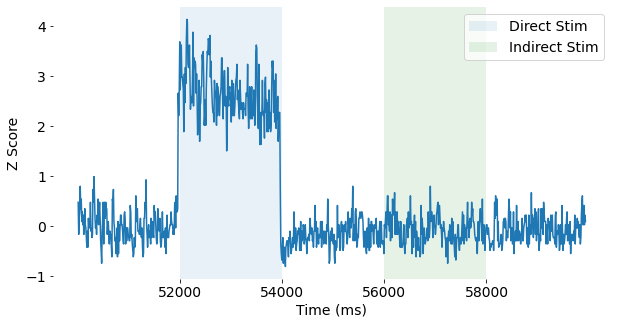

In [119]:
pth = "../../demyelination/data/eaone-noise-demy-reload-start/activity/"
f = ['spk_eaone-noise-demy-reload-start_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

ax.set_frame_on(False)
reload_time = 50000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);

ax.legend()

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

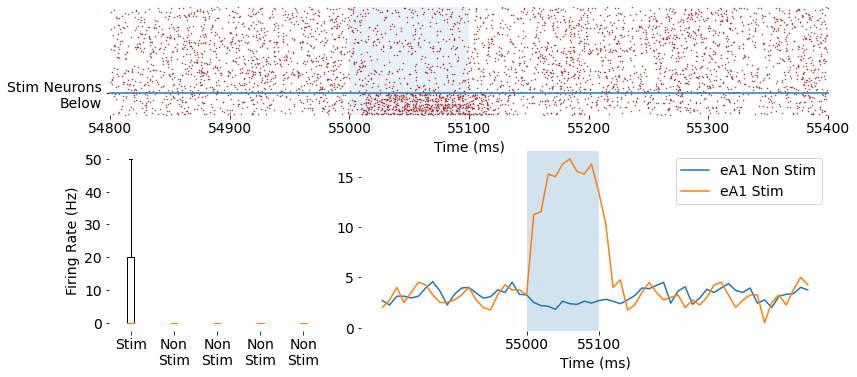

In [87]:
pth = "../../demyelination/data/eaone-noise-demy-reload-singlestim-start/activity/"
f = ['spk_eaone-noise-demy-reload-singlestim-start_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [55000, 55100])
ax.axvspan(20, 30, alpha=.2)
ax.set_xlabel("Time (ms)")

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+50000)

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 40000ms to 40100ms", fontsize=15);


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/tonostim-comparison-eaone.jpg")

In [47]:
import pipeline as pipeline

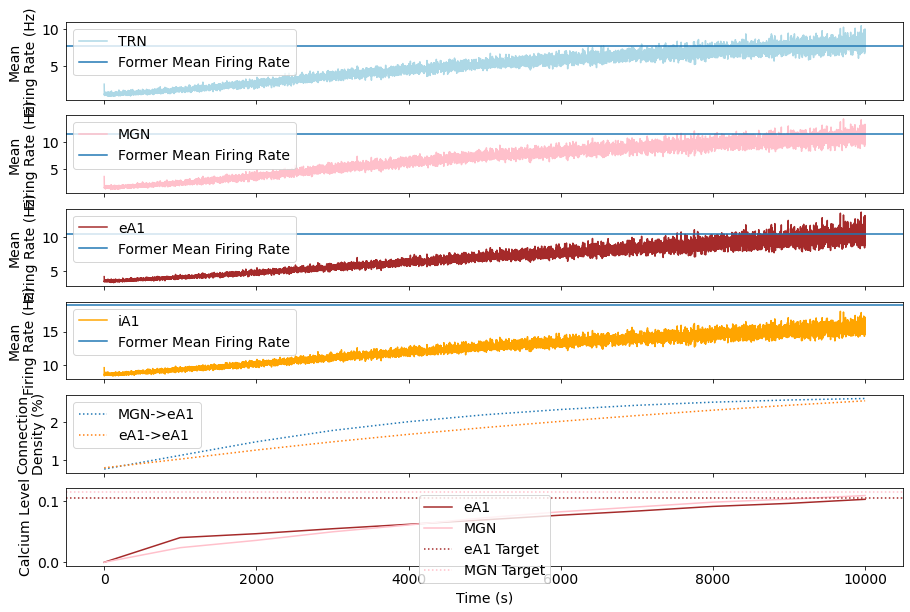

In [142]:
exp_name = 'eaone-demy-recurr'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 48

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

# DendriteType_Population
perc_mgn_eA1 = 100 * np.divide(ex_eA1, 2000*200)
perc_recurr_eA1 = 100 * np.divide(recurr_eA1, 2000*2000)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(15, 10)

tstart = 00 * 1000
tstop = 10001 * 1000
    
resolution = 1 * 1000

trn_spikeobj = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop)
x = trn_spikeobj.firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

mgn_spikeobj = gatherSpikes(pth, fl, nthread, "MGN", 1, 200)
x = mgn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

eaone_spikeobj = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400)
x = eaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

iaone_spikeobj = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop)
x = iaone_spikeobj.firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

[ax[_].set_ylabel("Mean\nFiring Rate (Hz)") for _ in range(4)]

x_range = np.arange(0, 10001, resolution)

ax[4].plot(x_range, perc_mgn_eA1[1:12], ":", label="MGN->eA1")
ax[4].plot(x_range, perc_recurr_eA1[1:12], ":", label="eA1->eA1")
ax[4].set_ylabel("Connection\nDensity (%)")

ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'][1:12], label="eA1", c='brown')
ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'][1:12], label="MGN", c='pink')
ax[5].axhline(.104, ls=":", label="eA1 Target", c='brown')
ax[5].axhline(.115, ls=":", label="MGN Target", color="pink")
ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

8.465
11.445
10.849998
16.118


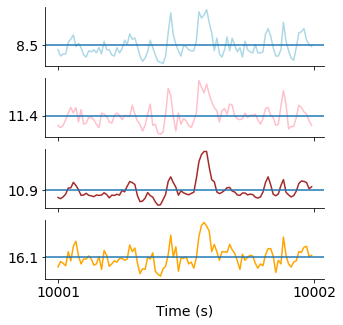

In [134]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.set_size_inches(5, 5)

tstart = 10000 * 1000
tstop = 10001 * 1000
    
resolution = 10

x = trn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(8.5, label="Mean Firing Rate")
print(np.mean(x))

x = mgn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.4, label="Mean Firing Rate")
print(np.mean(x))

x = eaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.8, label="Mean Firing Rate")
print(np.mean(x))

x = iaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(16.1, label="Mean Firing Rate")
print(np.mean(x))

plt.xlabel("Time (s)")

ax[0].set_yticks([8.5], [8.5])
ax[1].set_yticks([11.4], [11.4])
ax[2].set_yticks([10.9], [10.9])
ax[3].set_yticks([16.1], [16.1])

[_.spines[['right', 'top']].set_visible(False) for _ in ax]

ax[3].set_xticks([0, 100], [10001, 10002]);

In [50]:
tstart, tstop = 10000 * 1000, 10003 * 1000

print(
    "MFR\n",
    np.mean(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

print(
    "STD MFR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

resolution = 1
print(
    "STD Intantenous FR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True))
)

MFR
 12.106666666666666 8.698333333333334 11.435833333333331 16.514
STD MFR
 3.6267156859432292 2.0315832632593613 9.253701624215037 16.831426413441942
STD Intantenous FR
 9.030243 8.545798 5.8198195 6.943088


In [51]:
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)

In [52]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "mit"))
)

13.417370287620892 11.541164177986543 19.972333660356462 19.64117861952341


In [53]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "cerina"))
)

0.19431875314228253 0.36977357541873673 3.2501931307291354 2.0911683547989206


In [54]:
timebin = 20

ppc = {'MGN' : [], 'TRN' : [], 'eA1' : [], 'iA1' : []}

for _ in range(10):
    ppc['MGN'].append(mgn_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['TRN'].append(trn_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['eA1'].append(eaone_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['iA1'].append(iaone_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])

print(
    np.mean(ppc['MGN']),
    np.mean(ppc['TRN']),
    np.mean(ppc['eA1']),
    np.mean(ppc['iA1']),
)
    

0.027731304622161133 0.1372350174054131 0.023829822359556375 0.1324193656269047


In [55]:
from scipy import signal

In [56]:
resolution = 10
ifr_mgn = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_trn = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_eaone = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_iaone = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)

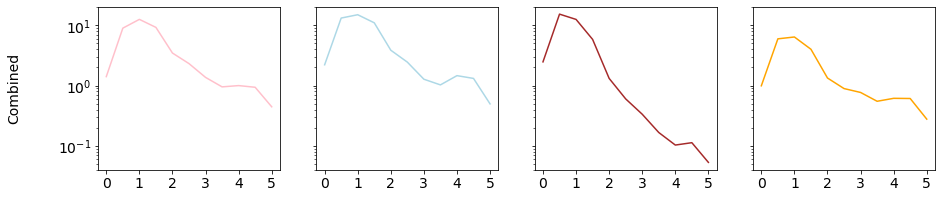

In [141]:
plt.rcParams.update({'font.size' : 14})

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3), sharey=True)

fs = 10
nps = 20

f, Pxx_den = signal.welch(ifr_mgn, fs, nperseg=nps)
ax[0].semilogy(f, Pxx_den, color='pink')

f, Pxx_den = signal.welch(ifr_trn, fs, nperseg=nps)
ax[1].semilogy(f, Pxx_den, color='lightblue')

f, Pxx_den = signal.welch(ifr_eaone, fs, nperseg=nps)
ax[2].semilogy(f, Pxx_den, color='brown')

f, Pxx_den = signal.welch(ifr_iaone, fs, nperseg=nps)
ax[3].semilogy(f, Pxx_den, color='orange')


ax[0].set_ylabel('Combined\n\n')
# ax[0].set_xlabel('Frequency (Hz)')

for idx in range(4):
    ax[idx].set_xticks([0, 1, 2, 3, 4, 5]);
    ax[idx].set_yticks([0.1, 1, 10])
    

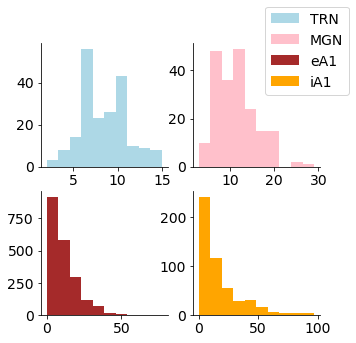

In [135]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(5, 5)

ax[0][0].hist(trn_spikeobj.time_slice(tstart, tstop).mean_rates(), color="lightblue", label='TRN')
ax[0][1].hist(mgn_spikeobj.time_slice(tstart, tstop).mean_rates(), color="pink", label='MGN')
ax[1][0].hist(eaone_spikeobj.time_slice(tstart, tstop).mean_rates(), color="brown", label='eA1')
ax[1][1].hist(iaone_spikeobj.time_slice(tstart, tstop).mean_rates(), color="orange", label='iA1')

ax = ax.reshape(-1)
[_.spines[['right', 'top']].set_visible(False) for _ in ax];

fig.legend()

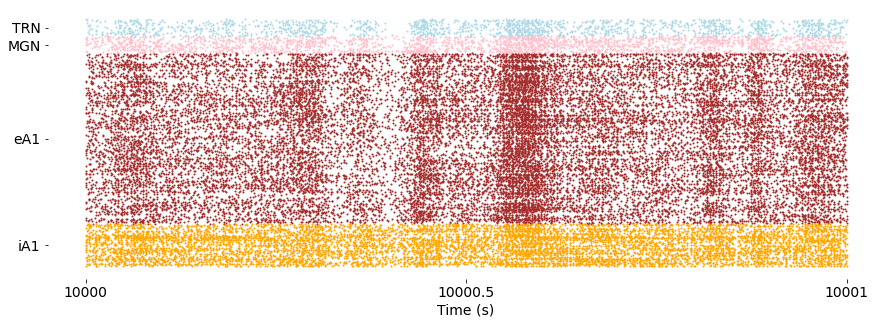

In [133]:

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches(15, 5)

ax.invert_yaxis()

color = {
    trn_spikeobj : 'lightblue',
    mgn_spikeobj : 'pink',
    eaone_spikeobj : 'brown',
    iaone_spikeobj : 'orange'
}

for spikeobj in [trn_spikeobj, mgn_spikeobj, eaone_spikeobj, iaone_spikeobj]:
    d = spikeobj.time_slice(tstart, tstop).raw_data()
    
    if spikeobj == trn_spikeobj:
        d[:, 1] = d[:, 1] - 200
    if spikeobj == mgn_spikeobj:
        d[:, 1] = d[:, 1] + 200

    ax.scatter(
        d[:, 0],
        d[:, 1],
        s=1,
        c=color[spikeobj]
               )
    
ax.set_frame_on(False)

# ax.set_axis_off()

ax.set_yticks([100, 300, 1400, 2650], ["TRN", "MGN", "eA1", "iA1"]);
ax.set_xticks([10000000, 10000500, 10001000], [10000, 10000.5, 10001]);
ax.set_xlabel("Time (s)");


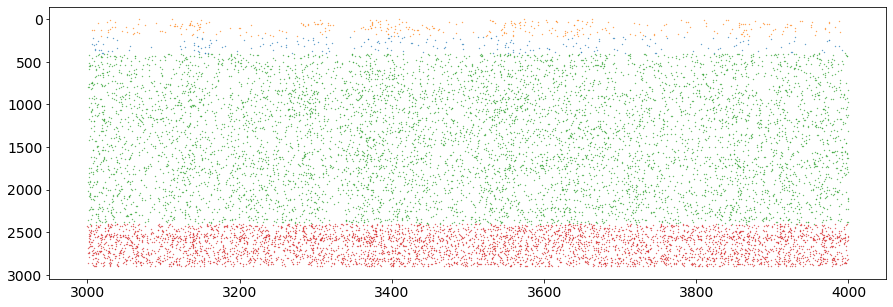

In [60]:

tstart, tstop = 3 * 1000, 4 * 1000

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches(15, 5)

ax.invert_yaxis()

for pop in ["TRN", "MGN", "eA1", "iA1"]:
    d = p.spikeobj[pop].time_slice(tstart, tstop).raw_data()

    ax.scatter(
        d[:, 0],
        d[:, 1],
        s=.1
               )
    
fig.set_frameon(False)


In [61]:
mgn_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=20000, time_bin=100)

(0.010036936981640071, 0.33958713316174105)

# MGN Stim Sensitivity

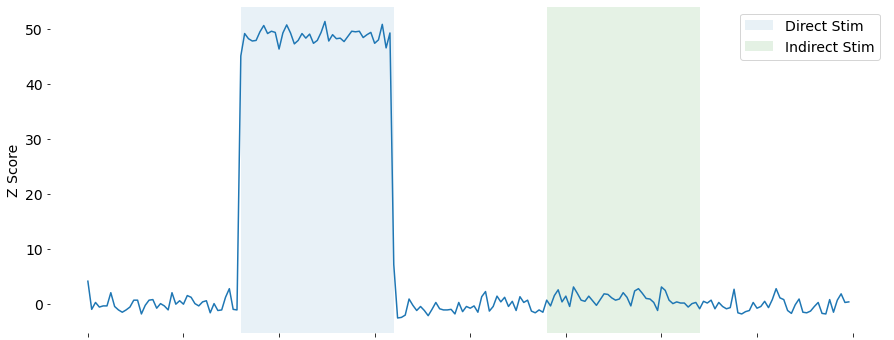

In [123]:
pth = "../../demyelination/data/eaone-noise-demy-reload-end/activity/"
f = ['spk_eaone-noise-demy-reload-end_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['MGN'].id_slice(range(1, 41))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 50

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(15, 6)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores)

ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
# ax.set_xticks([60, 140], ["Direct Stim", "Indirect Stim"]);

ax.legend()

# ax.set_xlabel("Time");
ax.set_ylabel("Z Score");